### <center> **Análise Preditiva:** Música

**Objetivo:** Prever a música que será a mais escutada ao final do ano. Retornar também as top 5 músicas.

In [236]:
# Importações
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from prophet import Prophet


In [227]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('spotify_songs_sofia.csv')

### Compreensão dos Dados

In [192]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25997 entries, 0 to 25996
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 25997 non-null  object 
 1   platform                           25997 non-null  object 
 2   ms_played                          25997 non-null  int64  
 3   conn_country                       25997 non-null  object 
 4   ip_addr                            25997 non-null  object 
 5   master_metadata_track_name         25997 non-null  object 
 6   master_metadata_album_artist_name  25997 non-null  object 
 7   master_metadata_album_album_name   25965 non-null  object 
 8   spotify_track_uri                  25997 non-null  object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      flo

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2023-04-04 18:25:30+00:00,android,11451,BR,177.76.148.44,Talk that Talk,TWICE,BETWEEN 1&2,spotify:track:0RDqNCRBGrSegk16Avfzuq,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632717,False,k-pop
1,2023-04-04 18:25:47+00:00,android,16559,BR,177.76.148.44,There's Nothing Holdin' Me Back,Shawn Mendes,Illuminate,spotify:track:7JJmb5XwzOO8jgpou264Ml,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632730,False,pop
2,2023-04-04 18:25:55+00:00,android,4168,BR,177.76.148.44,Woman,Doja Cat,Planet Her,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632747,False,pop
3,2023-04-04 19:23:17+00:00,android,80840,BR,177.76.148.44,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,clickrow,logout,False,False,False,1680635513,False,k-pop
4,2023-04-04 22:51:39+00:00,android,67760,BR,201.42.207.140,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,appload,logout,False,False,False,1680647986,False,k-pop


### Preparação de Dados

In [193]:
# COlunas necessárias: ts, ms_played, master_metadata_album_master_metadata_track_name, master_metadata_album_artist_name, shuffle, skipped

# Copiando os dados para outro df
df_music = df.copy()

# Excluindo colunas desnecessárias
df_music = df_music.drop(columns=['platform', 'conn_country', 'ip_addr', 'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name', 'episode_show_name', 'spotify_episode_uri', 'audiobook_uri', 'audiobook_title', 'audiobook_chapter_uri', 'audiobook_chapter_title', 'reason_start', 'reason_end', 'offline', 'offline_timestamp', 'incognito_mode', 'genero'])

# df limpo
display(df_music.head())

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped
0,2023-04-04 18:25:30+00:00,11451,Talk that Talk,TWICE,False,True
1,2023-04-04 18:25:47+00:00,16559,There's Nothing Holdin' Me Back,Shawn Mendes,False,True
2,2023-04-04 18:25:55+00:00,4168,Woman,Doja Cat,False,True
3,2023-04-04 19:23:17+00:00,80840,FLOWER,JISOO,False,False
4,2023-04-04 22:51:39+00:00,67760,FLOWER,JISOO,False,False


In [194]:
# apagar do df as músicas que foram puladas e estavam no modo aleatório
df_music.drop(
    df_music[(df_music['shuffle'] == True) & (df_music['skipped'] == True)].index, 
    inplace=True)

display(df_music.head())


,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped
0,2023-04-04 18:25:30+00:00,11451,Talk that Talk,TWICE,False,True
1,2023-04-04 18:25:47+00:00,16559,There's Nothing Holdin' Me Back,Shawn Mendes,False,True
2,2023-04-04 18:25:55+00:00,4168,Woman,Doja Cat,False,True
3,2023-04-04 19:23:17+00:00,80840,FLOWER,JISOO,False,False
4,2023-04-04 22:51:39+00:00,67760,FLOWER,JISOO,False,False


In [195]:
# Converter timestamp
df_music['ts'] = pd.to_datetime(df['ts'])

# Criar colunas úteis
df_music['ano'] = df_music['ts'].dt.year
df_music['mes'] = df_music['ts'].dt.to_period('M')

# Converter ms_played para minutos
df_music['min_played'] = df_music['ms_played'] / 60000

display(df_music)


C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_14600\2352705225.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_music['mes'] = df_music['ts'].dt.to_period('M')


,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped,ano,mes,min_played
0,2023-04-04 18:25:30+00:00,11451,Talk that Talk,TWICE,False,True,2023,2023-04,0.190850
1,2023-04-04 18:25:47+00:00,16559,There's Nothing Holdin' Me Back,Shawn Mendes,False,True,2023,2023-04,0.275983
2,2023-04-04 18:25:55+00:00,4168,Woman,Doja Cat,False,True,2023,2023-04,0.069467
3,2023-04-04 19:23:17+00:00,80840,FLOWER,JISOO,False,False,2023,2023-04,1.347333
4,2023-04-04 22:51:39+00:00,67760,FLOWER,JISOO,False,False,2023,2023-04,1.129333
...,...,...,...,...,...,...,...,...,...
25992,2026-01-29 22:55:17+00:00,122973,Famoso Machuca Xota,Mc Larissa,False,True,2026,2026-01,2.049550
25993,2026-01-29 22:55:20+00:00,2639,"Tá Duvidando Mulher, Nós Vareta Vareta",DJ 7W,False,True,2026,2026-01,0.043983
25994,2026-01-29 22:56:55+00:00,96005,Montagem Ritmo Brutal,MXZI,False,False,2026,2026-01,1.600083
25995,2026-01-29 22:57:07+00:00,9907,Agudo Mágico 6,MC K.K,False,True,2026,2026-01,0.165117


In [196]:
# Agregação mensal por música
df_month = (
    df_music.groupby(['mes', 'master_metadata_track_name', 'master_metadata_album_artist_name'])
      ['min_played'].sum()
      .reset_index()
)

df_month['mes'] = df_month['mes'].dt.to_timestamp()

display(df_month.head())

,mes,master_metadata_track_name,master_metadata_album_artist_name,min_played
0,2023-04-01,34+35,Ariana Grande,2.895167
1,2023-04-01,After LIKE,IVE,4.888217
2,2023-04-01,As If It's Your Last,BLACKPINK,0.325217
3,2023-04-01,As It Was,Harry Styles,5.576767
4,2023-04-01,Attention,NewJeans,6.002200


### Modelo

In [200]:
# Quantos meses faltam para o final do ano
ultimo_mes = df_month['mes'].max()

ano_atual = ultimo_mes.year
mes_atual = ultimo_mes.month

meses_restantes = 12 - mes_atual

In [ ]:
resultados = []
avaliacoes = []

for musica in df_month['master_metadata_track_name'].unique():

    # Filtrar música corretamente
    df_tmp = df_month[
        df_month['master_metadata_track_name'] == musica
    ][['mes', 'min_played', 'master_metadata_album_artist_name']].copy()

    df_tmp.columns = ['ds', 'y', 'artist']
    df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])
    df_tmp = df_tmp.dropna()
    df_tmp = df_tmp.sort_values('ds')

    # Evita séries curtas
    if len(df_tmp) < 3:
        continue

    artista = df_tmp['artist'].iloc[0]

    # Criar variável temporal
    df_tmp['t'] = np.arange(len(df_tmp))

    # Divisão de treino e teste
    n_test = 1
    train = df_tmp.iloc[:-n_test]
    test = df_tmp.iloc[-n_test:]

    X_train = train[['t']]
    y_train = train['y']

    X_test = test[['t']]
    y_test = test['y']

    # Modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Previsão do teste
    y_pred = model.predict(X_test)

    # Avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    avaliacoes.append([musica, artista, mae, rmse, r2])

    # Previsão
    prev_futuro = np.arange(len(df_tmp), len(df_tmp) + meses_restantes)
    prev_futuro = prev_futuro.reshape(-1, 1)

    previsoes = model.predict(prev_futuro)

    # SOmar as previsões até o final do ano
    total_previsto = previsoes.sum()

    resultados.append([musica, artista, total_previsto])

C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\skl

### Resultado das Avaliações

In [238]:
avaliacoes_ordenadas = sorted(avaliacoes, key=lambda x: x[1], reverse=False)

print(f"{'Música':<50} | {'MAE':^7} | {'RMSE':^7} | R2")	
for avaliacao in avaliacoes_ordenadas:
    print(f"{avaliacao[0]:<50} | {round(avaliacao[2], 4):^7} | {round(avaliacao[3], 4):^7} | {round(avaliacao[4], 4)}")

Música                                             |   MAE   |  RMSE   | R2
Nxde                                               |  0.628  |  0.628  | nan
Oh my god                                          | 3.1659  | 3.1659  | nan
Queencard                                          |  3.929  |  3.929  | nan
TOMBOY                                             | 0.5693  | 0.5693  | nan
I DO                                               | 5.6734  | 5.6734  | nan
Flip It                                            | 12.5201 | 12.5201 | nan
Deixe Me Ir (feat. Pablo Martins) - Acústico 1Kilo | 4.1213  | 4.1213  | nan
BANDITAS                                           | 0.6944  | 0.6944  | nan
Outro Dia                                          |  0.809  |  0.809  | nan
Vem No Galope                                      | 1.6467  | 1.6467  | nan
Tenta acreditar                                    | 5.3064  | 5.3064  | nan
Lisboa                                             | 0.6708  | 0.6708  | nan


### Resultado do Modelo (Previsão)

In [ ]:
df_result = pd.DataFrame(resultados, columns=['musica', 'artista', 'previsao_minutos'])

top5 = dfa_result.sort_values('previsao_minutos', ascending=False).head(5)

print(top5)

                                      musica        artista  previsao_minutos
1071             Apaga Apaga Apaga - Ao Vivo  Danilo e Davi       3529.558817
929                                 Soda Pop      Saja Boys       3028.575367
1148                            Te Esperando   Luan Santana       2318.868567
1016                                   10:35         Tiësto       1943.239100
1149  Tá Duvidando Mulher, Nós Vareta Vareta          DJ 7W       1828.637067


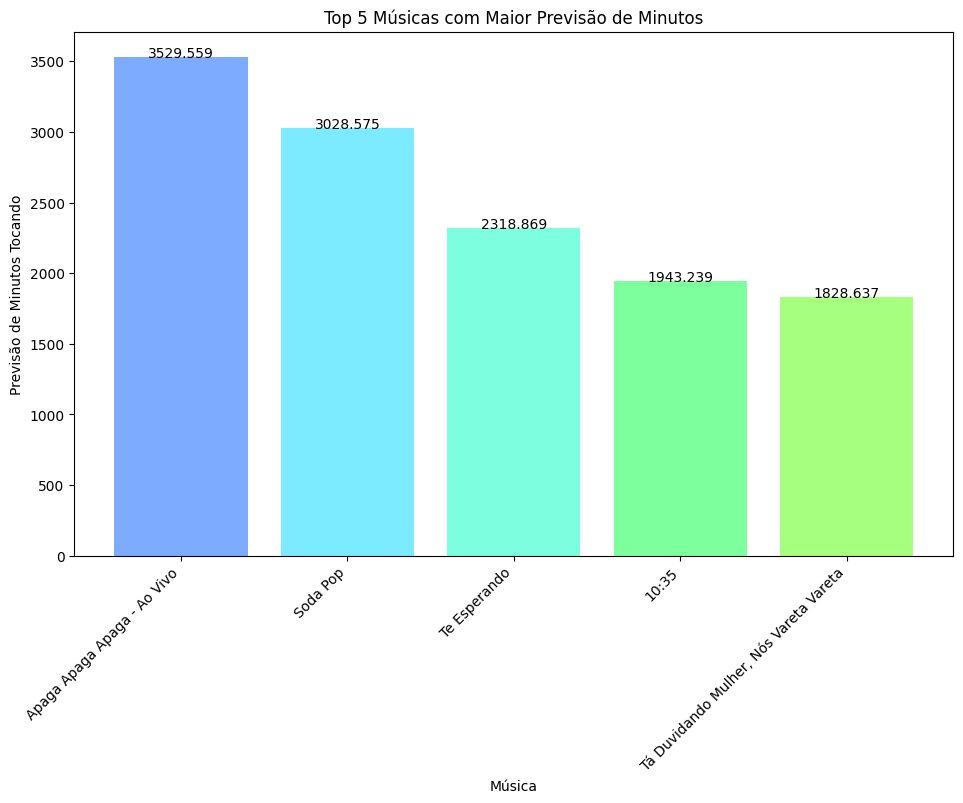

In [234]:
# Gráfico
plt.figure(figsize=(10, 6))

cores = ['#7DACFF', '#7DEBFF', '#7DFFDF', '#7DFF9E', '#A6FF7D']

plt.bar(top5['musica'], top5['previsao_minutos'], color=cores)
plt.title('Top 5 Músicas com Maior Previsão de Minutos')

for i, v in enumerate(top5['previsao_minutos']):
    plt.text(i, v, f"{v:.3f}", ha='center')

plt.tight_layout()
# plt.show()

plt.xlabel('Música')
plt.ylabel('Previsão de Minutos Tocando')
plt.xticks(rotation=45, ha='right')
plt.show()

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

# coeficientes
importancias = model.coef_

# nomes das colunas
features = X_train.columns

# criar DataFrame
df_importancia = pd.DataFrame({
    'feature': features,
    'importancia': importancias
})

# ordenar
df_importancia = df_importancia.sort_values(
    'importancia',
    key=abs,
    ascending=False
)

print(df_importancia)

  feature  importancia
0       t     3.234583


C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_14600\2961345345.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature', y='importancia', data=df_importancia, width=0.3, palette='viridis')


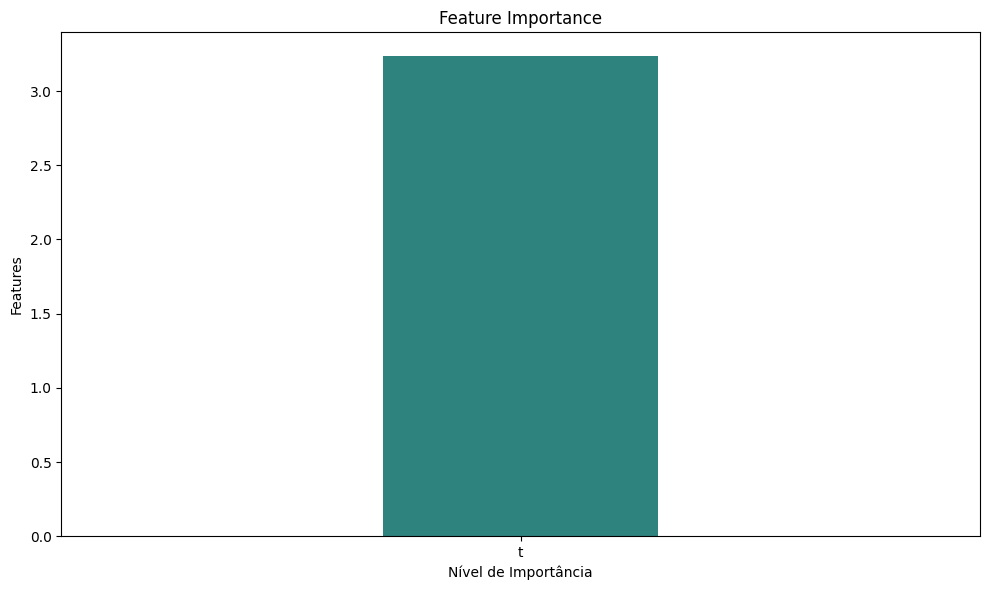

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo o tamanho da figura
plt.figure(figsize=(10, 6))

# Criando o gráfico de barras
sns.barplot(x='feature', y='importancia', data=df_importancia, width=0.3, palette='viridis')

# Adicionando títulos e labels
plt.title('Feature Importance')
plt.xlabel('Nível de Importância')
plt.ylabel('Features')

# Ajustando o layout para não cortar os nomes
plt.tight_layout()

plt.show()